cloning the github repo cotaining the dataset

In [1]:
!git clone https://github.com/mehdi-nait/Heart-Failure-Symptomes-detection.git

Cloning into 'Heart-Failure-Symptomes-detection'...
remote: Enumerating objects: 3374, done.
remote: Counting objects: 100% (3374/3374), done.
remote: Compressing objects: 100% (3338/3338), done.
remote: Total 3374 (delta 44), reused 3351 (delta 34), pack-reused 0
Receiving objects: 100% (3374/3374), 57.27 MiB | 27.90 MiB/s, done.
Resolving deltas: 100% (44/44), done.


In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset
import numpy as np
import cv2
import os
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
import Augmentor
#!pip install wandb
#import wandb


logging into wandb to track experiments

In [5]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Constructing Dataset class

In [ ]:
images_path = "Data/Dataset/Train/Images/" 
labels_path = "Data/Dataset/Train/Labels/"

NUM_SAMPLES = 3000

images = os.listdir(images_path)
labels = os.listdir(labels_path)

print(f"init size : {len(images)}")

images = [images_path+X for X in images]
labels = [labels_path+X for X in labels]

collected = list(zip(images,labels))

images = [[np.asarray(Image.open(y)) for y in x] for x in collected]

p = Augmentor.DataPipeline(images)

p.random_distortion(0.8,grid_height=15,grid_width=15,magnitude=5)
p.rotate(1, max_left_rotation=5, max_right_rotation=5)
p.flip_top_bottom(0.5)
p.zoom_random(0.5, percentage_area=0.7)

augmented_images= p.sample(NUM_SAMPLES)

for i in range(len(augmented_images)):
  
  cv2.imwrite(f"{images_path}{i}.png", augmented_images[i][0])
  cv2.imwrite(f"{labels_path}{i}.png", augmented_images[i][1])


print(f"end size : {len(os.listdir(images_path))}")


In [3]:
images_path = "Data/Dataset/Train/Images/" 
labels_path = "Data/Dataset/Train/Labels/"

images = os.listdir(images_path)
labels = os.listdir(labels_path)

print(len(images))
print(len(labels))
images = [images_path+X for X in images]
labels = [labels_path+X for X in labels]

for image in images:
  image = cv2.imread(image)
  image = cv2.resize(image,(150,150))

for image in labels:
  image = cv2.imread(image)
  image = cv2.resize(image,(150,150))

3526
3526


In [4]:
class Dataset_seg(Dataset):
    """A class used to represent the dataset
    
    Attributes
    ----------

    images : list(str)
        a list of image paths 
    labels : list(str)
        list of labels paths
    size_img : tuple(int,int)
        image and label size
    transform : function
        transformation to be applied on the images/labels
    
    Methods
    -------
    __init__(self,image_dir,label_dir,transform = None)
        instanciates the dataset object
    __len__(self)
        returns the length of the dataset
    __getitem__(self,idx)
        returns a image,label matrices couple after transforamations

    """
    
    def __init__(self,image_dir,label_dir,transform = None):

        
        self.images = os.listdir(image_dir)
        self.images = [image_dir+x for x in self.images]
        
        self.labels = os.listdir(label_dir)
        self.labels = [label_dir+x for x in self.labels]
        self.transform = transform
        self.size_img = (256,256)
        
    def __len__(self):

        return len(self.images)
    
    def __getitem__(self,idx):

        image = cv2.imread(self.images[idx], cv2.IMREAD_GRAYSCALE)
        label = cv2.imread(self.labels[idx], cv2.IMREAD_GRAYSCALE)
        
        image = cv2.resize(image,self.size_img)
        label = cv2.resize(label,self.size_img)
        
        image = cv2.equalizeHist(image)
        label = cv2.equalizeHist(label)

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)
        
        image = image.to(device)
        label = label.to(device)
        return image,label
        
        

# Building U-Net Model

Inspired from O. Ronneberger, P. Fischer, and T. Brox, “U-net: Convolutional networks for biomedical 
image segmentation,” 

In [5]:
class Block(nn.Module):
  """"""

  def __init__(self,in_channels,out_channels):
    
    super(Block,self).__init__()

    self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=3)
    self.relu  = nn.LeakyReLU()
    self.drop_out = nn.Dropout2d(p=0.5)
    self.batch_norm = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3)
    

  def forward(self,x):
    
    x = self.conv1(x)
    #x = self.drop_out(x)
    x = self.relu(x)
    x = self.batch_norm(x)
    x = self.conv2(x)
    #x = self.drop_out(x)
    x = self.relu(x)
    x = self.batch_norm(x)
    return x

In [6]:
class Encoder(nn.Module):

  def __init__(self,channels = (1,16,32,64)):
    super(Encoder,self).__init__()

    self.encode_blocks = nn.ModuleList(Block(channels[i],channels[i+1]) for i in range(len(channels)-1))
    self.pooling = nn.MaxPool2d(2,2)

  def forward(self,x):

    outputs = []

    for block in self.encode_blocks:

      x = block(x)
      outputs.append(x)
      x = self.pooling(x)

    return outputs

In [7]:
class Decoder(nn.Module):

  def __init__(self,channels = (64,32,16)):

    super(Decoder,self).__init__()

    self.channels = channels
    self.drop_out = nn.Dropout2d(p=0.5)
    self.up_convs  = nn.ModuleList(nn.ConvTranspose2d(channels[i],channels[i+1],2,2) for i in range(len(channels)-1))
    self.dec_blocks = nn.ModuleList(Block(channels[i],channels[i+1]) for i in range(len(channels)-1))
    self.batch_norms = nn.ModuleList(nn.BatchNorm2d(channels[i+1]) for i in range(len(channels)-1))

  def forward(self,x,enc_features):

    for i in range(len(self.channels)-1):
      
      x = self.up_convs[i](x)
      #x = self.drop_out(x)
      x = self.batch_norms[i](x)
      enc_feature = self.copy_crop(enc_features[i],x)
      x = torch.cat((enc_feature,x),dim=1)
      x = self.dec_blocks[i](x)

    
    return x


  def copy_crop(self,feature,x):

    _,_,H,W = x.shape
    cropped_feature = transforms.CenterCrop([H,W])(feature)
    return cropped_feature

In [8]:
class Unet(nn.Module):

  def __init__(self, enc_channels = (1,16,32,64), dec_channels = (64,32,16),nb_classes = 1, retainDim = True, out_size=(256,256)):
    super(Unet,self).__init__()

    self.encoder = Encoder(enc_channels)
    self.decoder = Decoder(dec_channels)
    
    self.head = nn.Conv2d(dec_channels[-1], nb_classes, 1)
    self.retainDim = retainDim
    self.outSize = out_size
    self.activation = nn.Sigmoid()
    

  
  def forward(self,x):

    enc_features = self.encoder(x)

    dec_features = self.decoder(enc_features[::-1][0],enc_features[::-1][1:])
		
    map = self.head(dec_features)
    map = self.activation(map)
    
    if self.retainDim:
      map = F.interpolate(map, self.outSize)
    
  
    return map

# Defining training metrics (loss & accuracy mesurement)

Here, we're using a Sigmoid Binary Cross Entropy loss function combined with dice loss, which yielded better results for dataset

In [9]:
class SoftDiceLoss(nn.Module):
  
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 1
        num = targets.size(0)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score = 2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = 1 - score.sum() / num
        return score
    

In [10]:
class BCE_DiceLoss(nn.Module):
  def __init__(self,weight = None,size_average = True):
    super(BCE_DiceLoss,self).__init__()
    
  def forward(self,logits,targets):
    bce = nn.BCEWithLogitsLoss()
    dice_loss = SoftDiceLoss()
    return bce(logits, targets) + (1-dice_metric(logits, targets))
    

Defining accuracy mesurement metrics, namely Dice coefficient and jaccard's index (Intersection over Union)

In [11]:
def dice_metric(output,label):

  intersection = 2.0* (output*label).sum()
  union = output.sum()+label.sum()

  if output.sum()==0 and label.sum()==0:
    return  1
  
  return intersection/union

In [12]:
def IoU_metric(output,label):
  
  intersection = (output*label).sum()
  union = output.sum()+label.sum() - intersection

  if output.sum()==0 and label.sum()==0:
    return  1
  
  return intersection/union

# Data preparation, and model training

In [14]:
EPOCHS = 20
BATCH_SIZE = 1
LR = 0.001
MOMENTUM = 0.99
ENC_CHANNELS = (1,16,32,64) 
DEC_CHANNELS = (64,32,16)

In [18]:
train_dir = "Data/Dataset/Train/"
valid_dir = "Data/Dataset/Test/"


train_dataset = Dataset_seg(train_dir+"/Images/",train_dir+"/Labels/",transforms.ToTensor())
valid_dataset = Dataset_seg(valid_dir+"/Images/",valid_dir+"/Labels/",transforms.ToTensor())

valid_dataloader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle = True)
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)


Storing Training configuration in logging interface (wandb)

In [16]:
config = {
  "Loss_function" : "BCE_DiceLoss",
  "Optimizer" : "SGD",
  "Learning_rate": LR,
  "Momentum":MOMENTUM,
  "Image_Size" : 256,
  "encoder layers":ENC_CHANNELS,
  "decoder layers":DEC_CHANNELS,
  "Epochs": EPOCHS,
  "Batch_size": BATCH_SIZE,
  "Device" : device
}

#wandb.init(config=wandb.config,project="U-Net", entity="mehdi-nait")


In [19]:
len(train_dataloader)

3526

In [20]:
model = Unet(enc_channels=ENC_CHANNELS, dec_channels=DEC_CHANNELS)
loss_function = BCE_DiceLoss()

optimizer = torch.optim.SGD(model.parameters(), lr = LR, momentum = MOMENTUM)
# initialize a dictionary to store training history
H = {"train_loss": [], "valid_loss": [], "train_dice": [], "train_IoU": [], "valid_dice": [], "valid_IoU": []}

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

117169

In [22]:
#test_dataset = Dataset_seg(train_dir+"/Images/",train_dir+"/Labels/",transforms.ToTensor())
test_dataset = Dataset_seg(valid_dir+"/Images/",valid_dir+"/Labels/",transforms.ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle = True)

[INFO] training in progress ...


  5%|▌         | 1/20 [00:53<17:05, 53.97s/it]

[INFO] EPOCH: 1/20
Train loss: 1.444359, Valid loss: 1.2453, Train DICE: 0.2754, Valid DICE: 0.4530, Train IoU: 0.1813, Valid IoU: 0.3273


 10%|█         | 2/20 [01:48<16:12, 54.02s/it]

[INFO] EPOCH: 2/20
Train loss: 1.291114, Valid loss: 1.0965, Train DICE: 0.4095, Valid DICE: 0.5963, Train IoU: 0.2914, Valid IoU: 0.4725


 15%|█▌        | 3/20 [02:41<15:15, 53.84s/it]

[INFO] EPOCH: 3/20
Train loss: 1.209512, Valid loss: 1.0586, Train DICE: 0.4886, Valid DICE: 0.6354, Train IoU: 0.3611, Valid IoU: 0.5051


 20%|██        | 4/20 [03:35<14:18, 53.65s/it]

[INFO] EPOCH: 4/20
Train loss: 1.158880, Valid loss: 0.9249, Train DICE: 0.5378, Valid DICE: 0.7644, Train IoU: 0.4075, Valid IoU: 0.6464


 25%|██▌       | 5/20 [04:28<13:25, 53.73s/it]

[INFO] EPOCH: 5/20
Train loss: 1.130575, Valid loss: 0.9423, Train DICE: 0.5651, Valid DICE: 0.7477, Train IoU: 0.4334, Valid IoU: 0.6322


 30%|███       | 6/20 [05:22<12:32, 53.76s/it]

[INFO] EPOCH: 6/20
Train loss: 1.109534, Valid loss: 0.9156, Train DICE: 0.5855, Valid DICE: 0.7738, Train IoU: 0.4527, Valid IoU: 0.6590


 35%|███▌      | 7/20 [06:16<11:39, 53.79s/it]

[INFO] EPOCH: 7/20
Train loss: 1.095910, Valid loss: 0.8897, Train DICE: 0.5989, Valid DICE: 0.7989, Train IoU: 0.4661, Valid IoU: 0.6905


 40%|████      | 8/20 [07:09<10:43, 53.65s/it]

[INFO] EPOCH: 8/20
Train loss: 1.083156, Valid loss: 0.8955, Train DICE: 0.6113, Valid DICE: 0.7933, Train IoU: 0.4784, Valid IoU: 0.6846


 45%|████▌     | 9/20 [08:03<09:49, 53.60s/it]

[INFO] EPOCH: 9/20
Train loss: 1.070331, Valid loss: 0.8764, Train DICE: 0.6236, Valid DICE: 0.8124, Train IoU: 0.4899, Valid IoU: 0.7070


 50%|█████     | 10/20 [08:56<08:53, 53.36s/it]

[INFO] EPOCH: 10/20
Train loss: 1.059833, Valid loss: 0.9230, Train DICE: 0.6338, Valid DICE: 0.7662, Train IoU: 0.5005, Valid IoU: 0.6518


 55%|█████▌    | 11/20 [09:49<07:59, 53.32s/it]

[INFO] EPOCH: 11/20
Train loss: 1.051760, Valid loss: 0.8782, Train DICE: 0.6418, Valid DICE: 0.8105, Train IoU: 0.5092, Valid IoU: 0.7061


 60%|██████    | 12/20 [10:42<07:05, 53.18s/it]

[INFO] EPOCH: 12/20
Train loss: 1.038727, Valid loss: 0.8727, Train DICE: 0.6542, Valid DICE: 0.8158, Train IoU: 0.5213, Valid IoU: 0.7126


 65%|██████▌   | 13/20 [11:34<06:11, 53.02s/it]

[INFO] EPOCH: 13/20
Train loss: 1.035750, Valid loss: 0.8752, Train DICE: 0.6572, Valid DICE: 0.8133, Train IoU: 0.5248, Valid IoU: 0.7083


 70%|███████   | 14/20 [12:28<05:18, 53.14s/it]

[INFO] EPOCH: 14/20
Train loss: 1.028685, Valid loss: 0.9080, Train DICE: 0.6639, Valid DICE: 0.7808, Train IoU: 0.5311, Valid IoU: 0.6764


 75%|███████▌  | 15/20 [13:21<04:25, 53.13s/it]

[INFO] EPOCH: 15/20
Train loss: 1.019667, Valid loss: 0.8548, Train DICE: 0.6727, Valid DICE: 0.8334, Train IoU: 0.5406, Valid IoU: 0.7337


 80%|████████  | 16/20 [14:14<03:32, 53.06s/it]

[INFO] EPOCH: 16/20
Train loss: 1.017794, Valid loss: 0.8832, Train DICE: 0.6745, Valid DICE: 0.8056, Train IoU: 0.5424, Valid IoU: 0.7027


 85%|████████▌ | 17/20 [15:08<02:39, 53.25s/it]

[INFO] EPOCH: 17/20
Train loss: 1.008159, Valid loss: 0.8637, Train DICE: 0.6837, Valid DICE: 0.8248, Train IoU: 0.5520, Valid IoU: 0.7237


 90%|█████████ | 18/20 [16:01<01:46, 53.30s/it]

[INFO] EPOCH: 18/20
Train loss: 1.007735, Valid loss: 0.8752, Train DICE: 0.6841, Valid DICE: 0.8136, Train IoU: 0.5525, Valid IoU: 0.7113


 95%|█████████▌| 19/20 [16:54<00:53, 53.22s/it]

[INFO] EPOCH: 19/20
Train loss: 1.007375, Valid loss: 0.8568, Train DICE: 0.6846, Valid DICE: 0.8316, Train IoU: 0.5523, Valid IoU: 0.7367


100%|██████████| 20/20 [17:47<00:00, 53.39s/it]

[INFO] EPOCH: 20/20
Train loss: 1.000939, Valid loss: 0.8645, Train DICE: 0.6907, Valid DICE: 0.8242, Train IoU: 0.5593, Valid IoU: 0.7226
[INFO] total time taken to train the model: 1070.67s


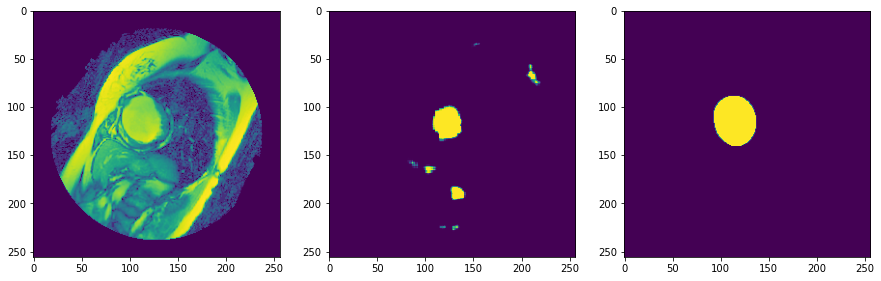

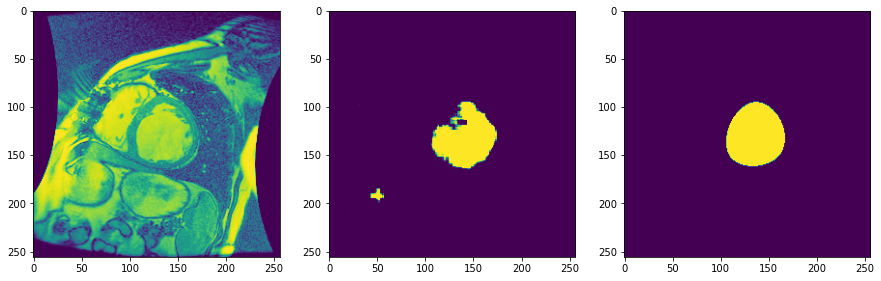

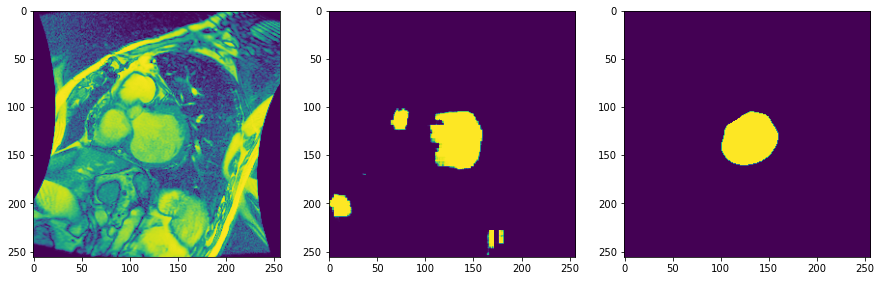

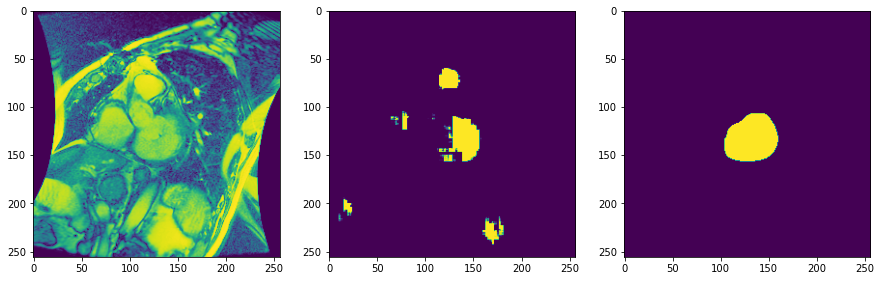

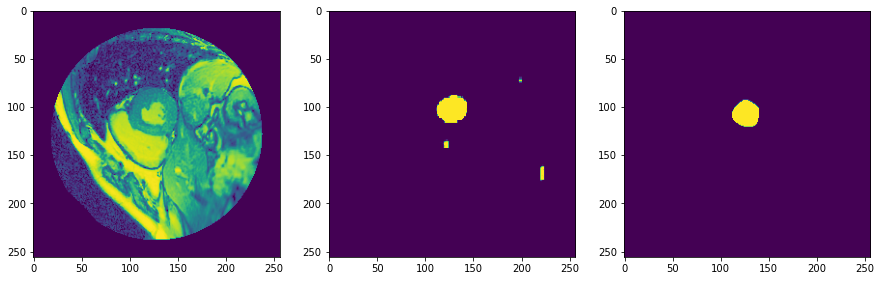

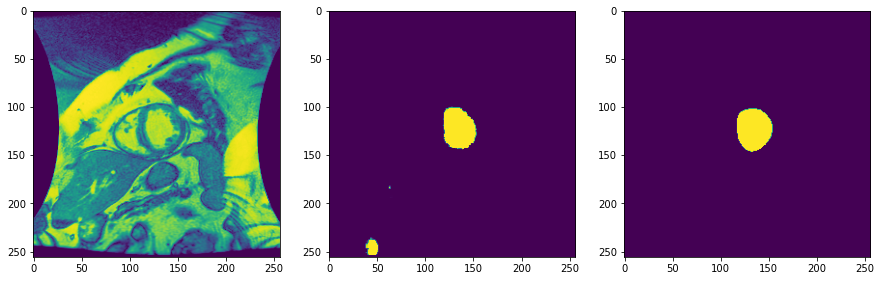

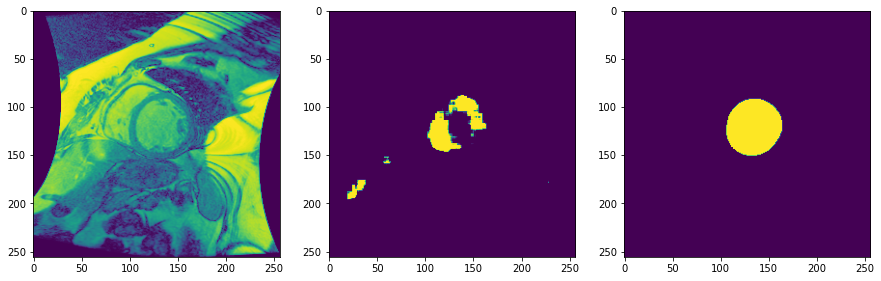

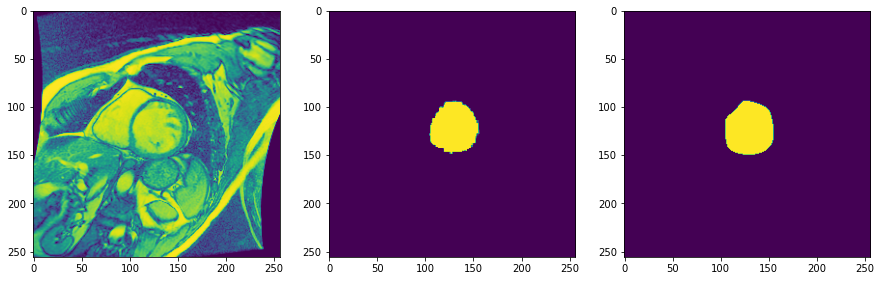

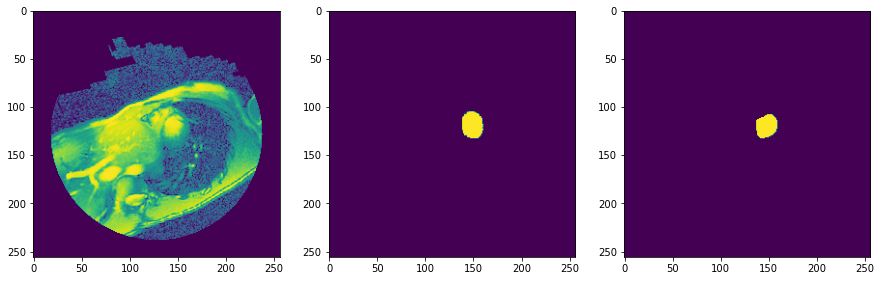

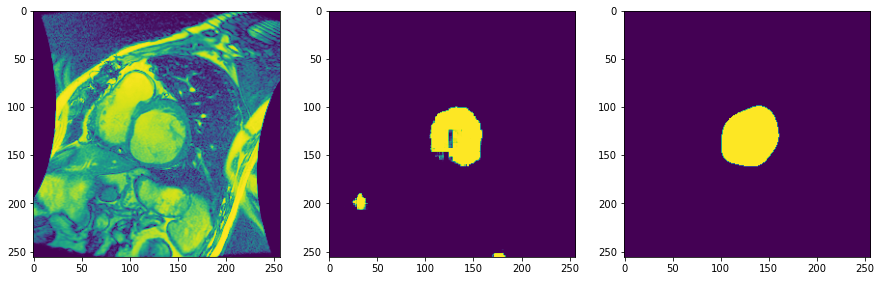

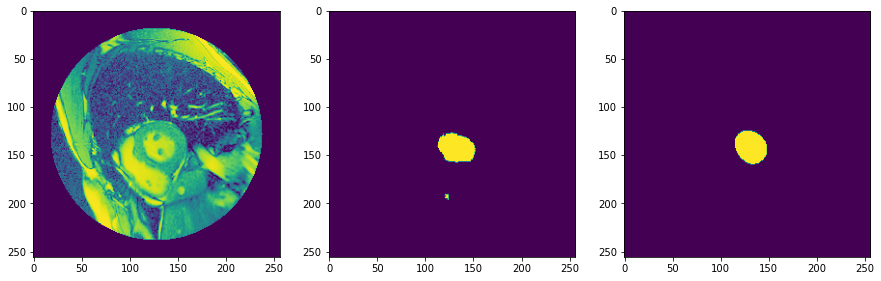

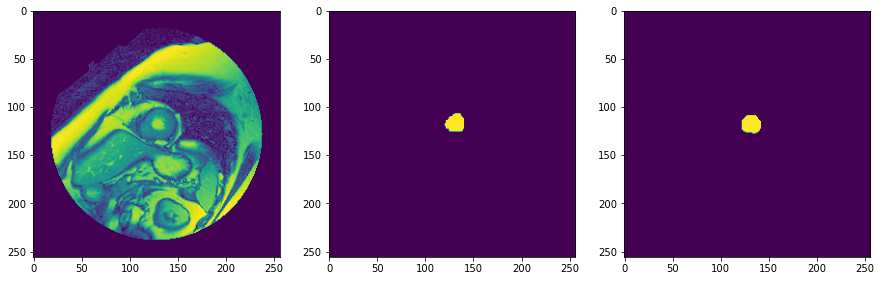

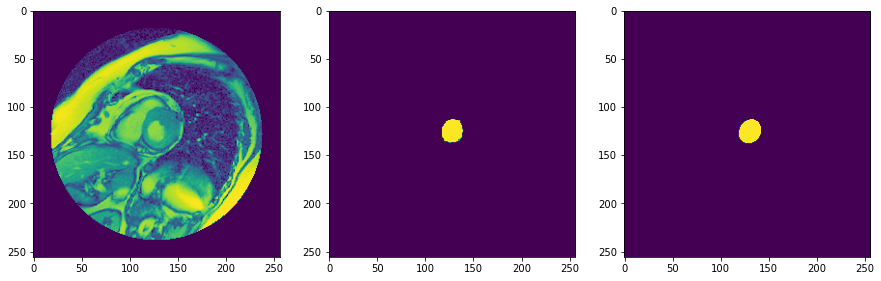

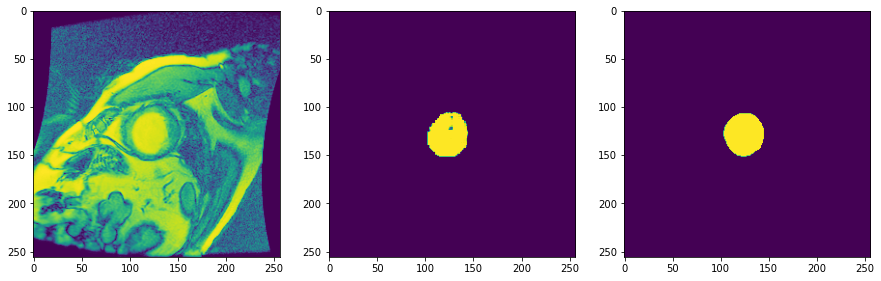

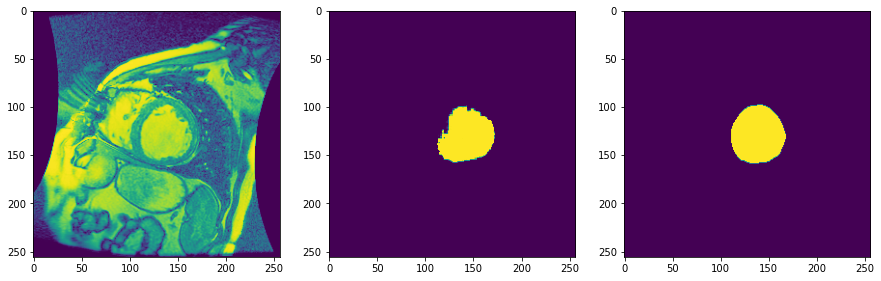

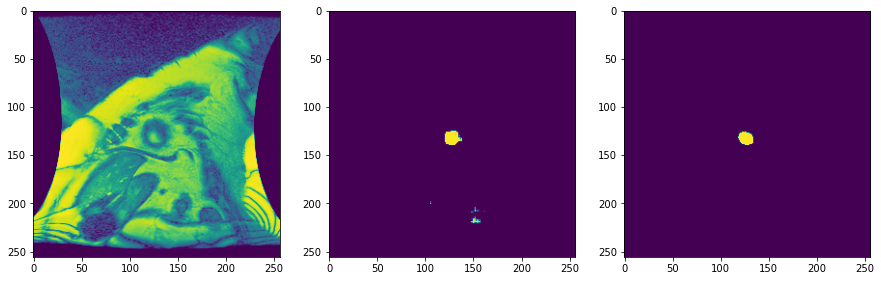

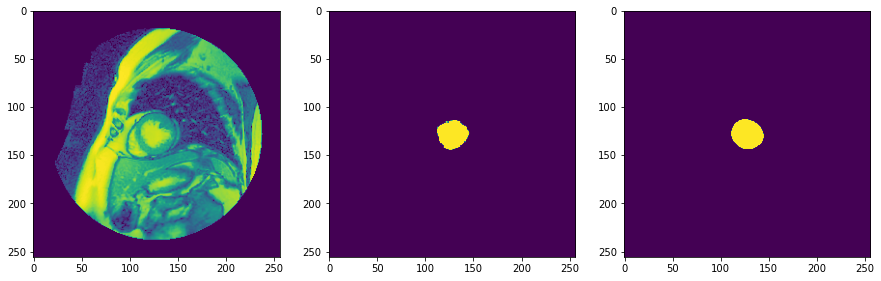

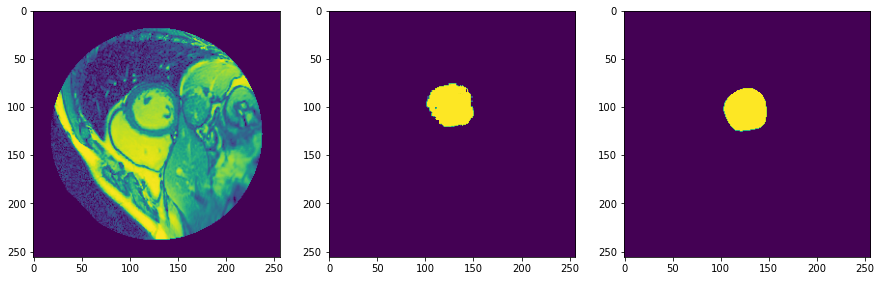

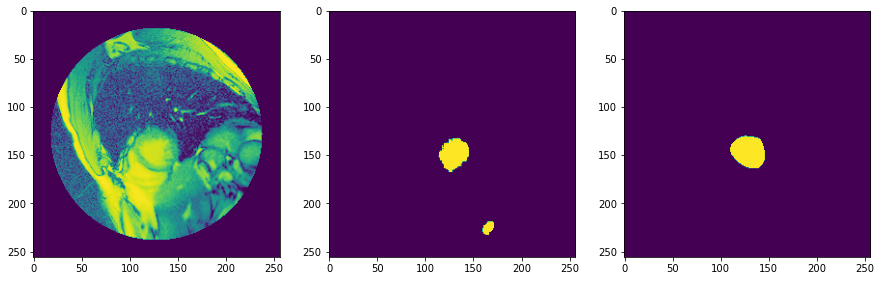

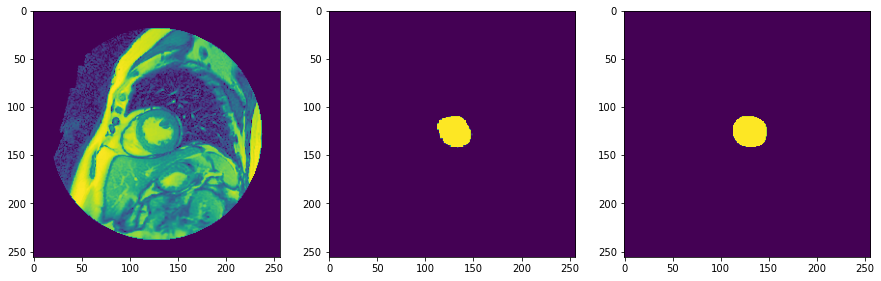

In [23]:
NUM_EPOCHS = config["Epochs"]

print("[INFO] training in progress ...")

start_time = time.time()

model = model.to(device)

for e in tqdm(range(NUM_EPOCHS)):

  model.train()

  total_train_loss = 0
  total_valid_loss = 0

  total_train_dice = 0
  total_valid_dice = 0

  total_train_IoU = 0
  total_valid_IoU = 0

  for (i, (x, y)) in enumerate(train_dataloader):
    
    optimizer.zero_grad()
    (x,y) = (x.to(device),y.to(device))

    pred = model(x)
    

    loss = loss_function(pred,y)
    
    loss.backward()

    optimizer.step()
    #pred = nn.Sigmoid()(pred)
    total_train_loss += loss.item()
    total_train_dice += dice_metric(pred,y).item()
    total_train_IoU  += IoU_metric(pred,y).item()

  with torch.no_grad():

    #model.eval()

    for (i, (x, y)) in enumerate(valid_dataloader):

      pred = model(x)

      total_valid_loss += loss_function(pred, y).item()
      #pred = nn.Sigmoid()(pred)
      total_valid_dice += dice_metric(pred,y).item()
      total_valid_IoU  += IoU_metric(pred,y).item()

  train_loss = total_train_loss / len(train_dataloader)
  valid_loss = total_valid_loss / len(valid_dataloader)

  train_dice = total_train_dice / len(train_dataloader)
  valid_dice = total_valid_dice / len(valid_dataloader)

  train_IoU  = total_train_IoU / len(train_dataloader)
  valid_IoU  = total_valid_IoU / len(valid_dataloader)


  H["train_loss"].append(train_loss)
  H["valid_loss"].append(valid_loss)

  H["train_dice"].append(train_dice)
  H["valid_dice"].append(valid_dice)

  H["train_IoU"].append(train_IoU)
  H["valid_IoU"].append(valid_IoU)
    
  ######################################################################
  img,label = next(iter(test_dataloader))

  model = model.to(device)
  img = img.to(device)
  output = model.forward(img)
  
  
  img = img.cpu().squeeze()
  output = output.cpu().detach().numpy().squeeze()
  label = label.cpu().squeeze()

  fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))

  ax1.imshow(img)
  ax2.imshow(output)
  ax3.imshow(label)
  #fig.colorbar()
  fig.show()
  
  ######################################################################

  print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
  print("Train loss: {:.6f}, Valid loss: {:.4f}, Train DICE: {:.4f}, Valid DICE: {:.4f}, Train IoU: {:.4f}, Valid IoU: {:.4f}".format(
      train_loss, valid_loss,train_dice,valid_dice,train_IoU,valid_IoU))
  
end_time = time.time()

print("[INFO] total time taken to train the model: {:.2f}s".format(end_time - start_time))

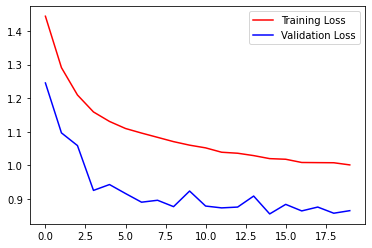

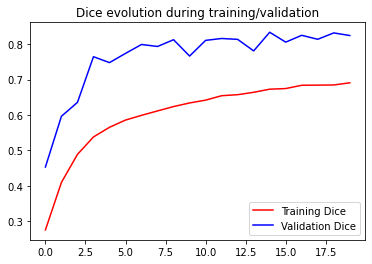

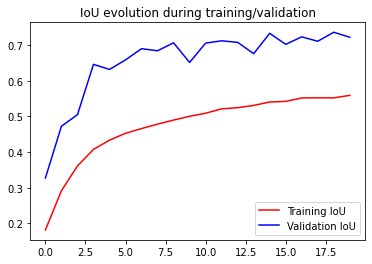

In [24]:
plt.plot(H["train_loss"],'r', label='Training Loss')
plt.plot(H["valid_loss"],'b', label='Validation Loss')
plt.legend()
plt.show()

plt.plot(H["train_dice"],'r', label='Training Dice')
plt.plot(H["valid_dice"],'b', label='Validation Dice')
plt.title("Dice evolution during training/validation")
plt.legend()
plt.show()

plt.plot( H["train_IoU"], 'r', label='Training IoU')
plt.plot(H["valid_IoU"], 'b', label='Validation IoU')
plt.title("IoU evolution during training/validation")
plt.legend()
plt.show()

https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py

In [28]:
model.train()

dice = 0
IoU = 0
model = model.to(device)
for i,(img,label) in enumerate(test_dataloader):
    
    img = img.to(device)
    output = model.forward(img)
    dice += dice_metric(output,label).item()
    IoU += IoU_metric(output,label).item()
    
print(f"Dice_metric avg : {(dice/len(test_dataloader))*100}% , IoU {(IoU/len(test_dataloader))*100:.3f}%")

Dice_metric avg : 3.6035552084292406% , IoU 1.850%


Dice_metric : 93.972% , IoU 88.629%


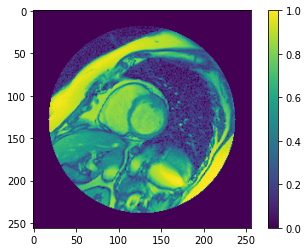

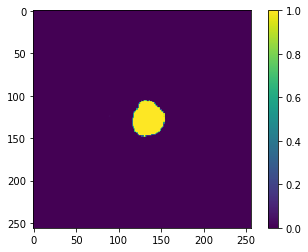

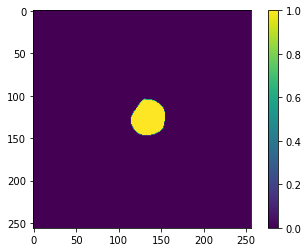

In [28]:
model.train()

img,label = next(iter(test_dataloader))

model = model.to(device)
img = img.to(device)
output = model.forward(img)

print(f"Dice_metric : {dice_metric(output,label)*100:.3f}% , IoU {IoU_metric(output,label)*100:.3f}%")

img = img.cpu().squeeze()
plt.imshow(img)
plt.colorbar()
plt.show()

output = output.cpu().detach().numpy().squeeze()
plt.imshow(output)
plt.colorbar()
plt.show()


label = label.cpu().squeeze()
plt.imshow(label)
plt.colorbar()

plt.show()


#img = wandb.Image(img, caption="Input image")
#label = wandb.Image(label, caption="Mask image")
#output = wandb.Image(output, caption="U-Net output")
          
#wandb.log({"Input": img, "label":label, "output":output})


# Test

In [25]:
#Model saving

EPOCH = 20
PATH = "Unet_512.pt"
learning_rate = 0.001

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'learning_rate': learning_rate,
            }, PATH)

In [ ]:
PATH = "Unet.pt"

model = Unet()
model = model.to(device)
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
print(model)

In [ ]:
img,label = next(iter(valid_dataloader))

output = model.forward(img)
#print(f"Accuracy : {dice_metric(output,label)*100} %")


intersection = 2.0* (output*label).sum()
output.sum()

In [ ]:
def dice_metric(output,label):

  intersection = 2.0* (output*label).sum()
  union = output.sum()+label.sum()

  if output.sum()==0 and label.sum()==0:
    return  1
  
  return intersection/union